## Initialization

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
import time
from IPython.display import Image
from tqdm.notebook import tqdm
plt.rcParams.update({'font.size': 15})

Define some physical constants.

In [2]:
mu0 = 4e-7*np.pi
c0 = 299792458
eps0 = 1/(c0**2*mu0)
hbar = 1.05457182e-34
kb = 1.380649e-23

Define some parameters related to the model.

In [3]:
#$\mu$ is dipole matrix element. This is set to e*1.3nm in the paper
mu = 1.60217663e-19*1.3e-9
#Lc is the total length of the 1d photonic lattice
Lc = 1.2e-4
#Lr is the total length of the system including the vaccum part.
Lr = 0.012/10
#Np is the number of periods of the photonic lattices.
Np = 12
#lp is the length of one period.
lp = Lc/Np

At first, we define some constants and parameters according to the paper. We will use the normalized time scale: $10^{-12}s = 1/\gamma$.

In [4]:
gamma = 1e12
gamma_normal = 1
gamma_c = 1e9/gamma
gamma_r = 1e13/gamma
Lambda_0 = 1e10/gamma
omega_0 = 1.6e14/gamma
N = 601
Temp_p = 400
Temp = 400
A = 1e-16
D = 2*mu**2/(hbar*eps0*A*Lc*gamma)
kb_normal = kb/(gamma**2)
hbar_normal = hbar/gamma

$f_a$ and $f_b$ are two functions related to the thermal relaxation.

In [5]:
def fa(omega_n,T):
    return 1/(1+np.exp(-hbar_normal*omega_n/(kb_normal*T)))
def fb(omega_n,T):
    return np.exp(-hbar_normal*omega_n/(kb_normal*T))/(1+np.exp(-hbar_normal*omega_n/(kb_normal*T)))             

Here we define a function that will give $\frac{d N}{d t}$ after input the initial conditions of $N_a$, $N_b$, $N_k$, eigen modes and temperatures.

In [6]:
def Ndtv3(Nmati, modes, LOmega, T, Tp, nw, nn=1):
    range_a = range(nn); range_ok = range(nn, nn+nw)
    Kernel = np.zeros((nn,nw))
    Ndti = np.zeros(nn+nw)
    for n in range_a:
        for k in range_ok:
            Kernel[n,k-nn] = ((2*Nmati[n] - N)*Nmati[k] + Nmati[n])*LOmega[n,k-nn]
    Kernel_sn = np.sum(Kernel, axis=0)
    Kernel_sk = np.sum(Kernel, axis=1)
    for n in range_a:
        Lambda_n = Lambda_0*np.exp(hbar_normal*(omega_0-modes[n])/(kb_normal*Tp))
        Ndti[n] =  -D*Kernel_sk[n] + Lambda_n*(N-Nmati[n]) - gamma_r*(Nmati[n] - N*fb(modes[n],T))
    for k in range_ok:
        Ndti[k] = D*Kernel_sn[k-nn] - gamma_c*Nmati[k]
    return Ndti 

## Load the eigemode data and prepare $\omega_n$ distribution

In [7]:
Tp=0.4

In [8]:
if Tp == 1:
    emodes = np.load("Emodes_0_6pi_Tp1_v4.npz")
    print('load Tp = 1 data')
elif Tp == 0.1:
    emodes = np.load("Emodes_0_6pi_Tp01_v4.npz")
    print('load Tp = 0.1 data')
elif Tp == 0.4:
    emodes = np.load("Emodes_0_6pi_Tp04_v4.npz")
    print('load Tp = 0.4 data')
elif Tp == 0.01:
    emodes = np.load("Emodes_0_6pi_Tp001_v4.npz")
    print('load Tp = 0.01 data')
else:
    emodes = np.load("Emodes_0_6pi_miscs.npz")
    print('load Tp = miscs data')
emodes.files

load Tp = 0.4 data


['ks', 'G_in', 'G_out', 'G_out_ep', 'emode_int']

In [9]:
ks = emodes["ks"]
G_in = emodes["G_in"]
G_out = emodes["G_out"]
G_out_ep = emodes["G_out_ep"]
Omega_k = ks/lp*c0/gamma

Here we assign the values of $\omega_n$ and the initial conditions of $N_a$ and $N_b$.

In [10]:
nn = 1000
omega_n = np.linspace(0.1,5.2e14,nn)/gamma
nw = len(Omega_k)
Nbni = np.zeros(nn)
Nki = np.zeros(nw)

To use Ndt function, we join the arrays of $N_a$, $N_b$ and $N_k$ and the arrays of $\omega_n$, $\Omega_k$ and G_in ($\Gamma_k$)

In [11]:
Ni = np.hstack((Nbni, Nki))
modes = np.hstack((omega_n, Omega_k, G_in)) 

To compute $\frac{dN}{dt}$ more efficiently, we compute $\Omega_k\Gamma_k L(\omega_n - \Omega_k)$ first and input the result to 'Ndtv3' function.

In [12]:
LOmega=[]
for omega in omega_n:
    LOmega.append(1/(1+((omega*np.ones(len(Omega_k)) - Omega_k)/gamma_normal)**2)*Omega_k*G_in)
LOmega = np.array(LOmega)
LOmegaT = np.transpose(LOmega)

## Solve equations of photon numbers 

### Use RK45 method

Use scipy's RK45 module to compute $N(t)$

In [44]:
nsol = integrate.RK45(lambda t, ni: Ndtv3(ni, modes, LOmega, Temp, Temp_p, nw=nw, nn=nn), 
                      t0=0, y0=Ni, t_bound = 10)
start_time = time.time()
t_values = []
y_values = []
i = 0
while nsol.status != 'finished':
    # get solution step state
    nsol.step()
    i += 1
    if (i%20) == 0:
        t_values.append(nsol.t)
        y_values.append(nsol.y)
        print(f"The time is: {nsol.t}")
t_values.append(nsol.t)
y_values.append(nsol.y)
y_values = np.array(y_values)
Nb = y_values[...,:nn]
Nk = y_values[...,nn:]
end_time = time.time()
print(f'\n The time used: {end_time-start_time}')

The time is: 2.022972477735816
The time is: 4.449754101097309
The time is: 6.867151930002024
The time is: 9.303668736034297

 The time used: 153.93709230422974


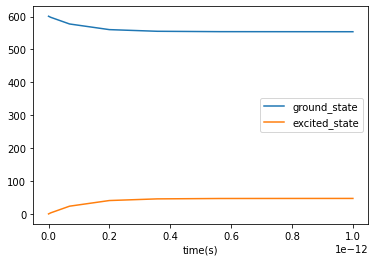

In [66]:
i = 1
tl = np.linspace(0,5e-13,len(Na))
plt.xlabel("time(s)")
plt.plot(t_values,Na[...,i], label="ground_state")
plt.plot(t_values,Nb[...,i], label="excited_state")
plt.legend()
plt.savefig("Na_Nb_wspread.png")

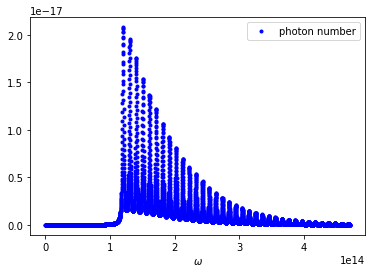

In [217]:
plt.xlabel("$\omega$")
plt.plot(Omega_k,Nk[-1],'b.', label="photon number")
plt.legend()
plt.savefig("Nk_Tp1_n40_ser.png")

Save data to the files

In [223]:
if Tp == 1:
    np.savez_compressed("Photon_n_0_6pi_Tp1_n50_cut1e-4", Nat = Na, Nbt = Nb, Nkt = Nk)
    print('save Tp = 1 photon number data')
elif Tp == 0.1:
    np.savez_compressed("Photon_n_0_6pi_Tp01_n50_cut1e-4", Nat = Na, Nbt = Nb, Nkt = Nk)
    print('save Tp = 0.1 photon number data')
elif Tp == 0.4:
    np.savez_compressed("Photon_n_0_6pi_Tp04_n50_cut1e-4", Nat = Na, Nbt = Nb, Nkt = Nk)
    print('save Tp = 0.4 photon number data')
elif Tp == 0.01:
    np.savez_compressed("Photon_n_0_6pi_Tp001_n50_cut1e-4", Nat = Na, Nbt = Nb, Nkt = Nk)
    print('save Tp = 0.01 photon number data')
else:
    np.savez_compressed("Photon_n_0_6pi_miscs_cut1e-4", Nat = Na, Nbt = Nb, Nkt = Nk)
    print('save Tp = misc photon number data')

save Tp = 0.01 photon number data


### Use Recrusive Method (only converge for passive cases or active cases with $\gamma_c \gtrapprox 10^{12}$)

Define the transpose of LOmega.

In [13]:
LOmegaT = np.transpose(LOmega)

Define several constant functions and arrays for computing $\frac{dN}{dt}$ and the recursive method.

In [14]:
fbn = fb(omega_n,Temp)
fan = fa(omega_n,Temp)
Ln = Lambda_0*np.exp(hbar_normal*(omega_0*np.ones(nn)-omega_n)/(kb_normal*Temp_p))

In [15]:
def A2_gen(gamma_r, nn, nw, Nb_f = True):
    if Nb_f:
        sign = 1.0
    else:
        sign = -1.0
    A2_00 = np.eye(nn, dtype=np.double)*(-D*np.sum(LOmega,axis=-1) - gamma_r*np.ones(nn) - Ln)
    A2_11 = np.eye(nw, dtype=np.double)*(-N*sign*D*np.sum(LOmega,axis=0) - gamma_c*np.ones(nw))
    A2_01 = N*D*LOmega
    LOmegaT = np.transpose(LOmega)
    A2_10 = sign*D*LOmegaT
    A2 = np.vstack([np.hstack([A2_00, A2_01]), np.hstack([A2_10, A2_11])])
    return A2

In [16]:
def B_gen(gamma_r, nw, Nb_f = True):
    if Nb_f:
        B = np.append(- N*Ln - gamma_r*N*fbn, np.zeros(nw))
    else:
        B = np.append(-N*D*np.sum(LOmega,axis=-1)- gamma_r*N*fan, -N*D*np.sum(LOmega,axis=0))
    return B

In [17]:
A1_00 = np.zeros((nn,nn))
A1_11 = np.zeros((nw,nw))

Define a function to compute $\frac{dN}{dt}$ in order to verify the derivative.

In [18]:
def Nbk_dt(N_ini, A2, B, Nb_f = True):
    if Nb_f:
        sign = 1.0
    else:
        sign = -1.0
    A1_01 = -2*D*LOmega*N_ini[:nn,None]
    A1_10 = 2*sign*D*LOmegaT*N_ini[nn:,None]
    A1 = np.vstack([np.hstack([A1_00, A1_01]), np.hstack([A1_10, A1_11])])
    A = A1 + A2
    return (A @ N_ini) - B

Compute some constant parts for the recursive method.

In [19]:
def b2_array(gamma_r, nn, nw, Nb_f = True):
    if Nb_f:
        b21 = gamma_r*N*fbn + Ln*N        
    else:
        b21 = gamma_r*N*fan + N*D*np.sum(LOmega,axis=-1)
    b20 = D*np.sum(LOmega,axis=-1) + gamma_r*np.ones(nn) + Ln
    k20 = N*D*np.sum(LOmega,axis=0) + gamma_c*np.ones(nw)
    return b20, b21, k20

Use the recursive method. Start from the initial guess of $N_k$, using the equations to compute $N_b$. And, then using the result of $N_b$ to compute $N_k$ until the maximum absolute value of $\frac{dN}{dt}$ is smaller than the value defined by 'tol'.

In [20]:
def N_rec_alt(Ni, nn, nw, b20, b21, k20, tol=1e-6, Nb_f = True):
    Nabn = Ni[:nn]
    Nk = Ni[nn:]
    tol_reached = False
    i = 0
    while (not tol_reached and i <= 10000):
        ksum = np.sum(LOmegaT*Nk[:,None],axis=0) 
        b0 = 2*D*ksum + b20
        b1 = N*D*ksum + b21
        Nabn = np.maximum(b1/b0, np.zeros(nn))
        Nabn = np.minimum(Nabn, np.ones(nn)*N)
        if Nb_f:
            bsum = np.sum(LOmega*Nabn[:,None],axis=0)
            k0 = -2*D*bsum + k20
            k1 = D*bsum
        else:
            asum = np.sum(LOmega*(N-Nabn[:,None]),axis=0)
            k0 = -2*D*asum + k20
            k1 = D*asum
        Nk = np.maximum(k1/k0, np.zeros(nw))
        i += 1
        if (i%100) == 0:
            Ni = np.hstack((Nabn,Nk))
            maxndt = np.max(np.abs(Nbk_dt(Ni, A2, B)))
            if maxndt < tol:
                tol_reached = True
            else:
                print(f"maximum value of dN/dt: {maxndt:.3e}")
    return np.hstack((Nabn,Nk))

In [21]:
gamma_r = 1e10/gamma
gamma_c = 1e13/gamma
A2 = A2_gen(gamma_r,nn,nw)
B = B_gen(gamma_r,nw)
b20, b21, k20 = b2_array(gamma_r,nn,nw)
Ni = np.zeros(nn+nw)
Ni2 = np.hstack((np.ones(nn)*N,np.ones(nw)))
start_time = time.time()
Nsol = N_rec_alt(Ni, nn=nn, nw=nw, b20=b20, b21=b21, k20=k20, tol=1e-9)
print(time.time() - start_time)
print(f'gamma_r = {gamma_r*gamma:.2e}')
print(f'gamma_c = {gamma_c*gamma:.2e}')

maximum value of dN/dt: 3.426e-02
maximum value of dN/dt: 7.423e-04
maximum value of dN/dt: 1.532e-05
maximum value of dN/dt: 3.148e-07
maximum value of dN/dt: 6.465e-09
32.21127367019653
gamma_r = 1.00e+10
gamma_c = 1.00e+13


In [22]:
dndt = Ndtv3(Nsol, modes, LOmega, Temp, Temp_p, nw=nw, nn=nn)
np.max(np.abs(dndt))

1.3274315674438597e-10

In [23]:
Nb = Nsol[:nn]
Nk = Nsol[nn:]
Na = N - Nb

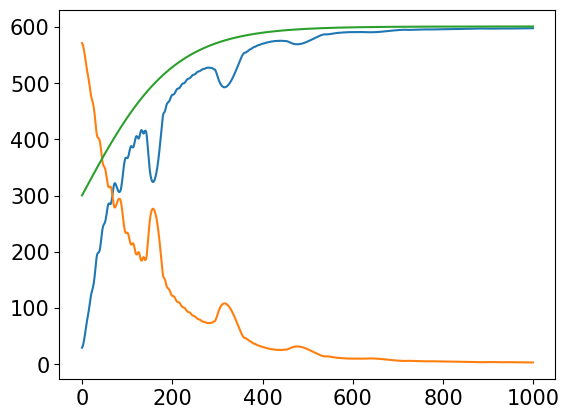

In [24]:
plt.plot(Na)
plt.plot(Nb)
plt.plot(N*fan)

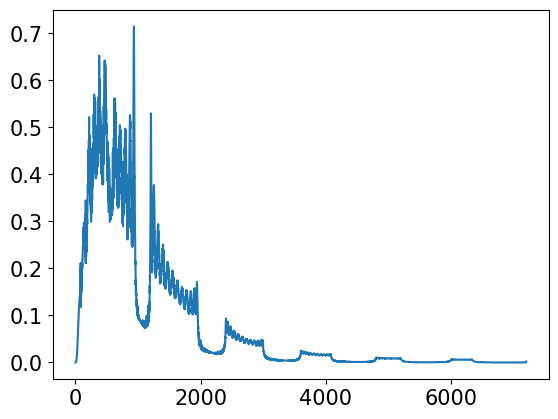

In [25]:
plt.plot(Nk)

Save the data to some file

In [44]:
str1 = 'Photon_n_0_6pi'
str2 = str(Tp)
str3 = str(nn)
str4 = str("{:.0e}".format(gamma_r*gamma))
str5 = str("{:.0e}".format(gamma_c*gamma))
file_name = str1+'_Tp'+str2+'_n'+str3+'_gr'+str4+'_gc'+str5
np.savez_compressed(file_name, Na = Na, Nb = Nb, Nk = Nk)
print(f'save Tp = {Tp:.2e} photon number data')

save Tp = 4.00e-01 photon number data
